In [1]:

import requests
from IPython.display import GeoJSON
import pandas as pd
import io



In [2]:
sensor_params = dict(
    sensor_type='PM2.5',
subset_layer='Post code Districts',
subset_shapes='NE1',
)

r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/csv/',sensor_params)

sensor_info = pd.read_csv(io.StringIO(r.text), encoding="ISO-8859-1")
sensor_info

,Sensor Name,Location (WKT),Ground Height Above Sea Level,Sensor Height Above Ground,Broker Name,Third Party,Sensor Centroid Longitude,Sensor Centroid Latitude,Raw ID


In [3]:
from datetime import datetime, timedelta

api_date_string_format = "%Y%m%d%H%M%S"

current_time = datetime.now()

start_time = current_time - timedelta(days=7)

start_time = datetime(start_time.year, start_time.month, start_time.day, start_time.hour)
end_time = datetime(current_time.year, current_time.month, current_time.day, current_time.hour)

data_params = dict(
    data_variable='PM2.5',
    agg_method='median',
    agg_period='15mins',
    starttime=start_time.strftime(api_date_string_format),
    endtime=end_time.strftime(api_date_string_format) 
)

data_params.update(sensor_params)
data_params

{'data_variable': 'PM2.5',
 'agg_method': 'median',
 'agg_period': '15mins',
 'starttime': '20230225160000',
 'endtime': '20230304160000',
 'sensor_type': 'PM2.5',
 'subset_layer': 'Post code Districts',
 'subset_shapes': 'NE1'}

In [6]:
r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/data/agg/csv/',data_params)
#data = pd.read_csv(io.StringIO(r.text), encoding_errors='ignore', sep=";")
#print(bonfire_data.head(10))
output = io.StringIO(r.text)
output.readlines()
#data.head(10)

['<!doctype html>\n',
 '<title>Site Maintenance</title>\n',
 '<style>\n',
 '  body { text-align: center; padding: 150px; }\n',
 '  h1 { font-size: 50px; }\n',
 '  body { font: 20px Helvetica, sans-serif; color: #333; }\n',
 '  article { display: block; text-align: left; width: 650px; margin: 0 auto; }\n',
 '  a { color: #dc8100; text-decoration: none; }\n',
 '  a:hover { color: #333; text-decoration: none; }\n',
 '</style>\n',
 '\n',
 '<article>\n',
 '    <h1>We&rsquo;ll be back soon!</h1>\n',
 '    <div>\n',
 '        <p>Sorry for the inconvenience but we&rsquo;re performing some maintenance at the moment. If you need to you can always <a href="mailto:#urbanobservatory@ncl.ac.uk">contact us</a>, otherwise we&rsquo;ll be back online shortly!</p>\n',
 '        <p>&mdash; The UO Team</p>\n',
 '    </div>\n',
 '  </br>\n',
 '    <img src="logo.svg" alt="Logo">\n',
 '</article>']

In [112]:
import smopy
import matplotlib.patheffects as pe

bbox = (
min(sensor_info['Sensor Centroid Latitude']),
    min(sensor_info['Sensor Centroid Longitude']),
    max(sensor_info['Sensor Centroid Latitude']),
    max(sensor_info['Sensor Centroid Longitude']),
)

map = smopy.Map(bbox, z=17)
ax = map.show_mpl(figsize=(15, 15))
for i,row in sensor_info.iterrows():
    x, y = map.to_pixels(row['Sensor Centroid Latitude'], row['Sensor Centroid Longitude'])
    ax.plot(x, y, 'ob', ms=20, mew=2);

ModuleNotFoundError: No module named 'smopy'

NameError: name 'data' is not defined

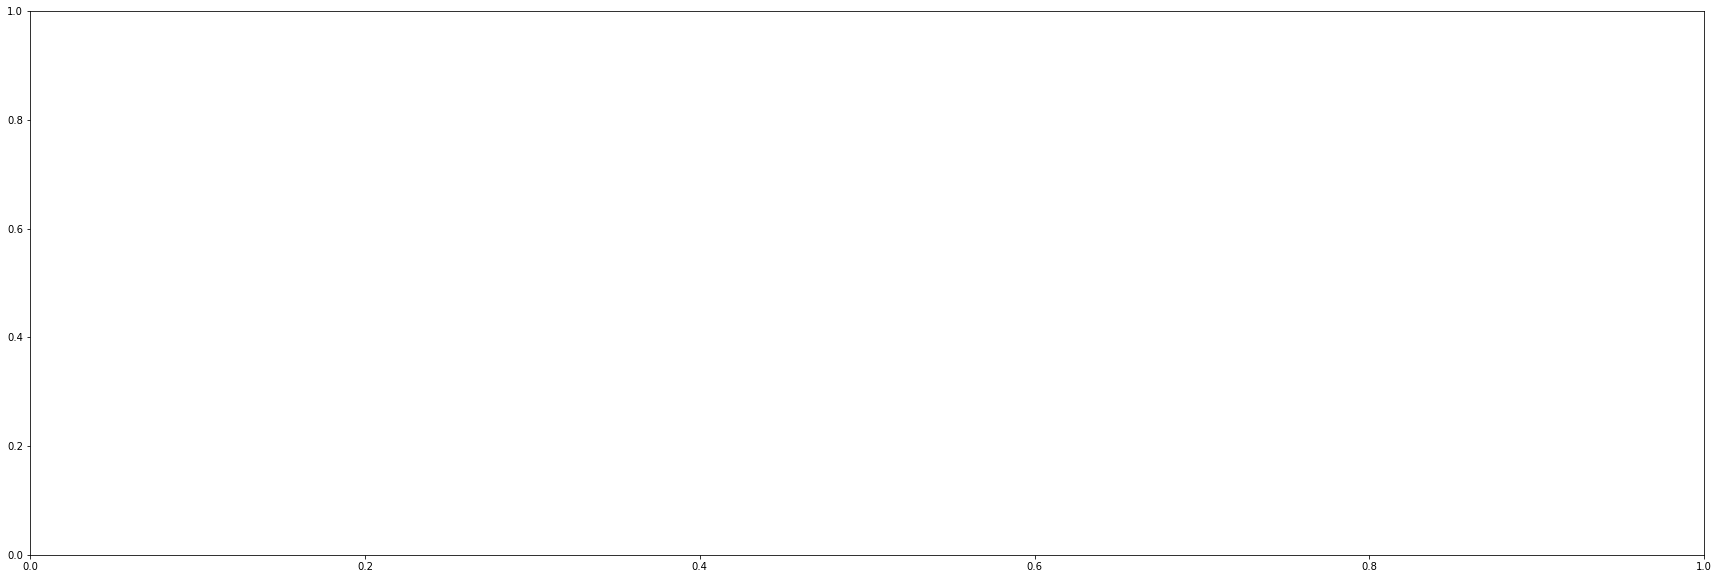

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,10))
for sensor_name,sensor_data in  data.groupby('Sensor Name'):
    
    datetimes = pd.to_datetime(sensor_data['Timestamp'])
    plt.plot(datetimes,sensor_data['Value'],label=sensor_name)

plt.legend()


In [1]:
%%javascript
require.config({
    paths: {
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [103]:
%%javascript
(function(element) {
    require(['d3'], function(d3) {   
        var data = [1, 2, 4, 8, 16, 8, 4, 2, 1]

        var svg = d3.select(element.get(0)).append('svg')
            .attr('width', 400)
            .attr('height', 200);
        svg.selectAll('circle')
            .data(data)
            .enter()
            .append('circle')
            .attr("cx", function(d, i) {return 40 * (i + 1);})
            .attr("cy", function(d, i) {return 100 + 30 * (i % 3 - 1);})
            .style("fill", "#1570a4")
            .transition().duration(2000)
            .attr("r", function(d) {return 2*d;})
        ;
    })
})(element);

<IPython.core.display.Javascript object>

In [106]:
%%javascript
(function(element) {
 require(['d3'], function(d3) { 
     
// Copyright 2022 Observable, Inc.
// Released under the ISC license.
// https://observablehq.com/@d3/spike-map
function SpikeMap(data, {
  position = d => d, // given d in data, returns the [longitude, latitude]
  value = () => undefined, // given d in data, returns the quantitative value
  title, // given a datum d, returns the hover text
  scale = d3.scaleLinear, // type of length scale
  domain, // [0, max] values; input of length scale; must start at zero
  maxLength = 200, // maximum length of spikes
  width = 640, // outer width, in pixels
  height, // outer height, in pixels
  projection, // a D3 projection; null for pre-projected geometry
  features, // a GeoJSON feature collection for the background
  borders, // a GeoJSON object for stroking borders
  spike = (length, width = 7) => `M${-width / 2},0L0,${-length}L${width / 2},0`,
  outline = projection && projection.rotate ? {type: "Sphere"} : null, // a GeoJSON object for the background
  backgroundFill = "#e0e0e0", // fill color for background
  backgroundStroke = "white", // stroke color for borders
  backgroundStrokeWidth, // stroke width for borders
  backgroundStrokeOpacity, // stroke width for borders
  backgroundStrokeLinecap = "round", // stroke line cap for borders
  backgroundStrokeLinejoin = "round", // stroke line join for borders
  fill = "red", // fill color for spikes
  fillOpacity = 0.3, // fill opacity for spikes
  stroke = "red", // stroke color for spikes
  strokeWidth, // stroke width for spikes
  strokeOpacity, // stroke opacity for spikes
  legendX = width - 20,
  legendY = height - 20,
} = {}) {
  // Compute values.
  const I = d3.map(data, (_, i) => i);
  const V = d3.map(data, value).map(d => d == null ? NaN : +d);
  const P = d3.map(data, position);
  const T = title == null ? null : d3.map(data, title);

  // Compute default domains.
  if (domain === undefined) domain = [0, d3.max(V)];

  // Construct scales.
  const length = scale(domain, [0, maxLength]);

  // Compute the default height. If an outline object is specified, scale the projection to fit
  // the width, and then compute the corresponding height.
  if (height === undefined) {
    if (outline === undefined) {
      height = 400;
    } else {
      const [[x0, y0], [x1, y1]] = d3.geoPath(projection.fitWidth(width, outline)).bounds(outline);
      const dy = Math.ceil(y1 - y0), l = Math.min(Math.ceil(x1 - x0), dy);
      projection.scale(projection.scale() * (l - 1) / l).precision(0.2);
      height = dy;
    }
  }

  // Construct a path generator.
  const path = d3.geoPath(projection);

  const svg = d3.create("svg")
      .attr("width", width)
      .attr("height", height)
      .attr("viewBox", [0, 0, width, height])
      .attr("style", "width: 100%; height: auto; height: intrinsic;");

  if (outline != null) svg.append("path")
      .attr("fill", "white")
      .attr("stroke", "currentColor")
      .attr("d", path(outline));

  svg.append("path")
      .datum(features)
      .attr("fill", backgroundFill)
      .attr("d", path);

  if (borders != null) svg.append("path")
      .attr("pointer-events", "none")
      .attr("fill", "none")
      .attr("stroke", backgroundStroke)
      .attr("stroke-linecap", backgroundStrokeLinecap)
      .attr("stroke-linejoin", backgroundStrokeLinejoin)
      .attr("stroke-width", backgroundStrokeWidth)
      .attr("stroke-opacity", backgroundStrokeOpacity)
      .attr("d", path(borders));

  const legend = svg.append("g")
      .attr("fill", "#777")
      .attr("text-anchor", "middle")
      .attr("font-family", "sans-serif")
      .attr("font-size", 10)
    .selectAll("g")
      .data(length.ticks(4).slice(1).reverse())
    .join("g")
      .attr("transform", (d, i) => `translate(${legendX - i * 18},${legendY})`);

  legend.append("path")
      .attr("fill", "red")
      .attr("fill-opacity", 0.3)
      .attr("stroke", "red")
      .attr("d", d => spike(length(d)));

  legend.append("text")
      .attr("dy", "1.3em")
      .text(length.tickFormat(4, "s"));

  svg.append("g")
      .attr("fill", fill)
      .attr("fill-opacity", fillOpacity)
      .attr("stroke", stroke)
      .attr("stroke-width", strokeWidth)
      .attr("stroke-opacity", strokeOpacity)
    .selectAll("path")
    .data(d3.range(data.length)
        .filter(i => P[i])
        .sort((i, j) => d3.ascending(P[i][1], P[j][1]) || d3.ascending(P[i][0], P[j][0])))
    .join("path")
      .attr("transform", projection == null
          ? i => `translate(${P[i]})`
          : i => `translate(${projection(P[i])})`)
      .attr("d", i => spike(length(V[i])))
      .call(T ? path => path.append("title").text(i => T[i]) : () => {});

  return svg.node();
}
 })
});



<IPython.core.display.Javascript object>

In [111]:
%%javascript
(function(element) {
  require(['d3'], function(d3) {
    
    
    
    chart = SpikeMap(population, {
      value: ([population]) => +population,
      position([, stateid, countyid]) {
        const county = countymap.get(stateid + countyid);
        return county && centroid(county);
      },
      title([population, stateid, countyid]) {
        const state = statemap.get(stateid);
        const county = countymap.get(stateid + countyid);
        return `${county?.properties.name}, ${state?.properties.name}\n${(+population).toLocaleString("en")}`;
      },
      features: nation,
      borders: statemesh,
      width: 975,
      height: 610
        
    })
  }(element))
});

<IPython.core.display.Javascript object>